In [1]:
from pathlib import Path

import torch
from torch.utils.data import DataLoader

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.utils.config import Config
from neuralhydrology.datasetzoo import get_dataset
from neuralhydrology.datautils.utils import load_scaler

In [2]:
run_dir = Path("./runs/lstm_1207_111556")
config = Config(run_dir / "config.yml")
config.as_dict()

{'batch_size': 512,
 'clip_gradient_norm': 1,
 'commit_hash': '8ab0ef3',
 'data_dir': PosixPath('../data/CAMELS_KZ'),
 'dataset': 'generic',
 'device': 'cuda:0',
 'dynamic_inputs': ['prcp',
  'srad',
  't_max',
  't_min',
  'pp_mean',
  'sat_max',
  'hum_mean',
  'dew_min',
  'discharge_prev',
  'level_prev'],
 'epochs': 20,
 'experiment_name': 'lstm',
 'head': 'regression',
 'hidden_size': 128,
 'img_log_dir': PosixPath('/home/spectre/Projects/ISSAI/Internship/aqua_rate/ML/runs/lstm_1207_111556/img_log'),
 'initial_forget_bias': 3,
 'learning_rate': {0: 0.01, 10: 0.001, 30: 0.0001, 40: 1e-05},
 'log_interval': 5,
 'log_tensorboard': True,
 'loss': 'NSE',
 'metrics': ['NSE', 'KGE'],
 'model': 'cudalstm',
 'num_workers': 8,
 'number_of_basins': 42,
 'optimizer': 'Adam',
 'output_activation': 'linear',
 'output_dropout': 0.4,
 'package_version': '1.10.0',
 'predict_last_n': 1,
 'run_dir': PosixPath('/home/spectre/Projects/ISSAI/Internship/aqua_rate/ML/runs/lstm_1207_111556'),
 'save_vali

In [3]:
config.update_config({"seq_length": 1})

In [4]:
model = CudaLSTM(cfg=config)
model

CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (model): CudaLSTMCore(
    (lstm): LSTM(32, 128)
    (dropout): Dropout(p=0.4, inplace=False)
    (head): Regression(
      (net): Sequential(
        (0): Linear(in_features=128, out_features=1, bias=True)
      )
    )
  )
)

In [5]:
model.load_state_dict(torch.load(run_dir / "model_epoch020.pt"))
model

CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (model): CudaLSTMCore(
    (lstm): LSTM(32, 128)
    (dropout): Dropout(p=0.4, inplace=False)
    (head): Regression(
      (net): Sequential(
        (0): Linear(in_features=128, out_features=1, bias=True)
      )
    )
  )
)

In [6]:
ds = get_dataset(cfg=config, is_train=False, period="test", scaler=load_scaler(run_dir))
loader = DataLoader(ds, batch_size=1, num_workers=0, collate_fn=ds.collate_fn)

The following basins had not enough valid target values to calculate a standard deviation: 11163, 13035, 19013. NSE loss values for this basin will be NaN.


In [7]:
data = next(iter(loader))
pred = model(data)

In [8]:
pred["y_hat"].shape

torch.Size([1, 1, 1])

In [9]:
data["y"].squeeze(0, -1).detach().numpy().shape

(1,)

<Axes: >

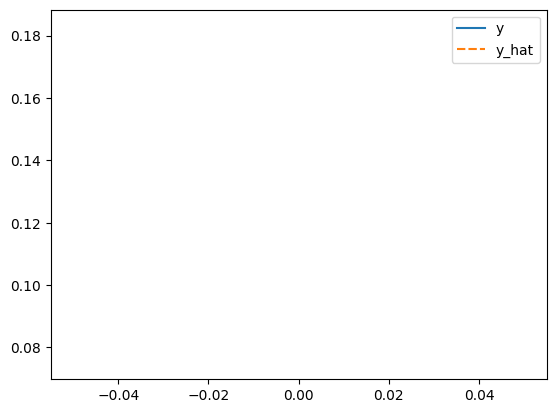

In [10]:
df = pd.DataFrame({
    "y": data["y"].squeeze(0, -1).detach().numpy(),
    "y_hat": pred["y_hat"].squeeze(0, -1).detach().numpy(),
})

sns.lineplot(df)

In [11]:
data = [sample for i, sample in enumerate(loader) if i == 365][0]
pred = model(data)

<Axes: >

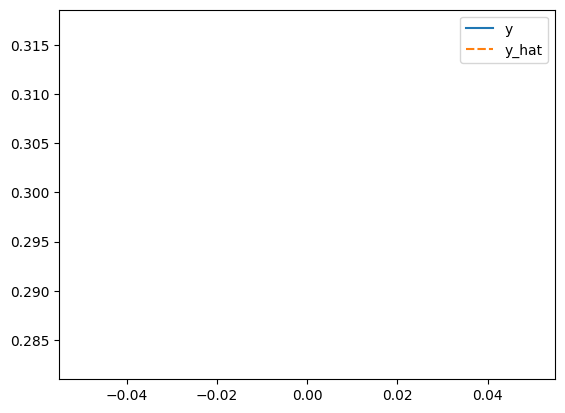

In [12]:
df = pd.DataFrame({
    "y": data["y"].squeeze(0, -1).detach().numpy(),
    "y_hat": pred["y_hat"].squeeze(0, -1).detach().numpy(),
})

sns.lineplot(df)

In [13]:
predictions = []
actual = []

for i, data in enumerate(loader):
    if i == 365 * 2:
        break
    x = model.pre_model_hook(data, is_train=False)
    actual.append(x["y"].detach().numpy()[0][0][0])
    del x["y"]

    # print()
    # print(x["x_d"].shape)
    # print("x_d: ", x["x_d"][0][0][9])
    # try:
    #     print("last_pred: ", prediction["y_hat"].squeeze(0, -1))
    # except:
    #     pass

    # if i > 0:
    #     x["x_d"][0][-1][9] = predictions[-1]

    # print("x_d_prev", x["x_d"][0][0][9])

    prediction = model(x)
    predictions.append(prediction["y_hat"].detach().numpy()[0][0][0])
    # print("current_pred: ", prediction["y_hat"])
    # if i == 3:
    #     break

In [14]:
len(predictions), len(actual)

(730, 730)

In [15]:
actual

[0.18292283,
 0.1719643,
 0.17074668,
 0.16912319,
 0.1679056,
 0.1662821,
 0.16506448,
 0.16384688,
 0.1622234,
 0.16100577,
 0.15938228,
 0.15816468,
 0.15775882,
 0.15775882,
 0.15735292,
 0.15694706,
 0.15694706,
 0.15654118,
 0.15613532,
 0.15572946,
 0.15572946,
 0.15532357,
 0.15532357,
 0.15532357,
 0.15532357,
 0.15532357,
 0.15532357,
 0.1549177,
 0.1549177,
 0.1549177,
 0.1549177,
 0.1549177,
 0.15694706,
 0.1589764,
 0.16141163,
 0.16344099,
 0.16547035,
 0.1674997,
 0.16993496,
 0.1719643,
 0.17399366,
 0.17602302,
 0.17805238,
 0.17967583,
 0.18129933,
 0.18292283,
 0.1845463,
 0.1861698,
 0.18779327,
 0.18941675,
 0.19104025,
 0.19266373,
 0.19428723,
 0.19591069,
 0.19794004,
 0.19956353,
 0.20118703,
 0.20281051,
 0.204434,
 0.20605747,
 0.22391582,
 0.24218002,
 0.26003835,
 0.2762732,
 0.29656675,
 0.31280163,
 0.33309516,
 0.34933004,
 0.3696236,
 0.38585845,
 0.4102107,
 0.43456298,
 0.46297398,
 0.48732623,
 0.5116785,
 0.5360308,
 0.5603831,
 0.5887941,
 0.613146

<Axes: >

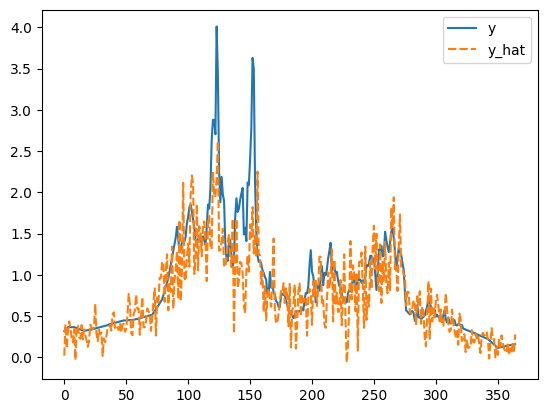

In [16]:
df = pd.DataFrame({
    "y": actual[365:],
    "y_hat": predictions[365:],
})

sns.lineplot(df)

In [11]:
next(iter(loader))['x_d'].shape, next(iter(loader))['x_s'].shape, next(iter(loader))['y'].shape

(torch.Size([1, 365, 10]), torch.Size([1, 22]), torch.Size([1, 365, 1]))

In [12]:
for data in loader:
    for key in data:
        if not key.startswith('date'):
            data[key] = data[key].to("cuda")

In [13]:
next(iter(loader))

{'x_d': tensor([[[-0.3361, -1.0030, -1.6943,  ..., -1.9821,  0.3249,  0.0599],
          [-0.3361, -1.0140, -1.5761,  ..., -2.1448,  0.3290,  0.0599],
          [-0.3361, -0.9820, -1.6812,  ..., -2.0634,  0.3290,  0.0858],
          ...,
          [-0.3361, -1.0301, -1.2312,  ..., -1.4211,  0.1857, -0.0696],
          [-0.3361, -1.1649, -1.1984,  ..., -1.0914,  0.1902, -0.0567],
          [ 0.1848, -1.1343, -1.2542,  ..., -1.0572,  0.1942, -0.0567]]]),
 'y': tensor([[[   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan]

In [14]:
input_data = model_lstm.pre_model_hook(next(iter(loader)), is_train=False)

In [15]:
input_data

{'x_d': tensor([[[-0.3361, -1.0030, -1.6943,  ..., -1.9821,  0.3249,  0.0599],
          [-0.3361, -1.0140, -1.5761,  ..., -2.1448,  0.3290,  0.0599],
          [-0.3361, -0.9820, -1.6812,  ..., -2.0634,  0.3290,  0.0858],
          ...,
          [-0.3361, -1.0301, -1.2312,  ..., -1.4211,  0.1857, -0.0696],
          [-0.3361, -1.1649, -1.1984,  ..., -1.0914,  0.1902, -0.0567],
          [ 0.1848, -1.1343, -1.2542,  ..., -1.0572,  0.1942, -0.0567]]]),
 'y': tensor([[[   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan]

In [16]:
pred = model_lstm(input_data)

In [17]:
pred

{'y_hat': tensor([[[ 1.8648e-02],
          [-6.2468e-02],
          [-3.7423e-02],
          [-7.5205e-02],
          [ 2.1293e-02],
          [-4.4056e-03],
          [ 2.3969e-01],
          [-3.4571e-02],
          [-1.6828e-01],
          [-1.1205e-01],
          [-6.3946e-02],
          [ 1.0819e-02],
          [ 1.6373e-04],
          [-1.7956e-01],
          [-1.0694e-01],
          [ 1.9756e-01],
          [ 1.2559e-01],
          [ 2.1452e-02],
          [-3.6350e-01],
          [ 2.6217e-01],
          [ 4.8798e-02],
          [ 2.0511e-01],
          [-1.5484e-01],
          [-4.5281e-02],
          [ 2.7673e-01],
          [-2.6210e-01],
          [ 1.8491e-01],
          [ 1.7059e-01],
          [ 1.0251e-01],
          [ 4.7822e-01],
          [ 1.6325e-01],
          [ 2.9026e-01],
          [ 3.1735e-01],
          [ 2.1961e-01],
          [-9.4856e-02],
          [-1.6361e-01],
          [-4.2429e-02],
          [ 2.1902e-01],
          [ 1.5313e-01],
          [-8.06

In [18]:
pred["y_hat"], pred["y_hat"].shape

(tensor([[[ 1.8648e-02],
          [-6.2468e-02],
          [-3.7423e-02],
          [-7.5205e-02],
          [ 2.1293e-02],
          [-4.4056e-03],
          [ 2.3969e-01],
          [-3.4571e-02],
          [-1.6828e-01],
          [-1.1205e-01],
          [-6.3946e-02],
          [ 1.0819e-02],
          [ 1.6373e-04],
          [-1.7956e-01],
          [-1.0694e-01],
          [ 1.9756e-01],
          [ 1.2559e-01],
          [ 2.1452e-02],
          [-3.6350e-01],
          [ 2.6217e-01],
          [ 4.8798e-02],
          [ 2.0511e-01],
          [-1.5484e-01],
          [-4.5281e-02],
          [ 2.7673e-01],
          [-2.6210e-01],
          [ 1.8491e-01],
          [ 1.7059e-01],
          [ 1.0251e-01],
          [ 4.7822e-01],
          [ 1.6325e-01],
          [ 2.9026e-01],
          [ 3.1735e-01],
          [ 2.1961e-01],
          [-9.4856e-02],
          [-1.6361e-01],
          [-4.2429e-02],
          [ 2.1902e-01],
          [ 1.5313e-01],
          [-8.0654e-03],


In [19]:
model = model_lstm.model
model

CudaLSTMCore(
  (lstm): LSTM(32, 128)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [20]:
next(iter(loader))

{'x_d': tensor([[[-0.3361, -1.0030, -1.6943,  ..., -1.9821,  0.3249,  0.0599],
          [-0.3361, -1.0140, -1.5761,  ..., -2.1448,  0.3290,  0.0599],
          [-0.3361, -0.9820, -1.6812,  ..., -2.0634,  0.3290,  0.0858],
          ...,
          [-0.3361, -1.0301, -1.2312,  ..., -1.4211,  0.1857, -0.0696],
          [-0.3361, -1.1649, -1.1984,  ..., -1.0914,  0.1902, -0.0567],
          [ 0.1848, -1.1343, -1.2542,  ..., -1.0572,  0.1942, -0.0567]]]),
 'y': tensor([[[   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan]

In [21]:
a = next(iter(loader))
a["x_s"] = a["x_s"].unsqueeze(0).expand(1, 365, 22)

In [22]:
a["x_s"].shape

torch.Size([1, 365, 22])

In [23]:
input_data = torch.cat([a["x_d"], a["x_s"]], dim=2)
input_data, input_data.shape

(tensor([[[-0.3361, -1.0030, -1.6943,  ...,  0.5518,  1.8709,  1.4554],
          [-0.3361, -1.0140, -1.5761,  ...,  0.5518,  1.8709,  1.4554],
          [-0.3361, -0.9820, -1.6812,  ...,  0.5518,  1.8709,  1.4554],
          ...,
          [-0.3361, -1.0301, -1.2312,  ...,  0.5518,  1.8709,  1.4554],
          [-0.3361, -1.1649, -1.1984,  ...,  0.5518,  1.8709,  1.4554],
          [ 0.1848, -1.1343, -1.2542,  ...,  0.5518,  1.8709,  1.4554]]]),
 torch.Size([1, 365, 32]))

In [24]:
loader = DataLoader(ds, batch_size=1024, num_workers=0, collate_fn=ds.collate_fn)

In [25]:
for data in loader:
    for key in data:
        if not key.startswith('date'):
            data[key] = data[key].to("cuda")

In [26]:
input_data = next(iter(loader))
input_data["x_d"].shape, input_data["x_s"].shape

(torch.Size([1024, 365, 10]), torch.Size([1024, 22]))

In [27]:
input_data["x_s"] = input_data["x_s"].unsqueeze(0).expand(365, 1024, 22).swapaxes(0, 1)
input_data["x_d"].shape, input_data["x_s"].shape

(torch.Size([1024, 365, 10]), torch.Size([1024, 365, 22]))

In [28]:
input_data = torch.cat([input_data["x_d"], input_data["x_s"]], dim=2)
input_data.shape

torch.Size([1024, 365, 32])

In [29]:
import shap


# batch = next(iter(loader))
# images, _ = batch

background = input_data
# test_images = images[100:103]

e = shap.DeepExplainer(model, background)
# shap_values = e.shap_values(test_images)

In [30]:
shap_values = e.shap_values(input_data, check_additivity=False)

/home/spectre/Projects/ISSAI/Internship/aqua_rate/.venv/lib/python3.10/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f'unrecognized nn.Module: {module_type}')


KeyboardInterrupt: 

In [ ]:
# input_data.squeeze(0).shape

torch.Size([365, 32])

In [ ]:
shap_values.shape

(1, 365, 32, 1)

In [ ]:
import numpy as np


# shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(background.numpy(), 1, -1), 1, 2)
test_numpy.shape

(1, 365, 32)

In [ ]:
test_numpy = test_numpy.squeeze(0)
test_numpy.shape

(365, 32)

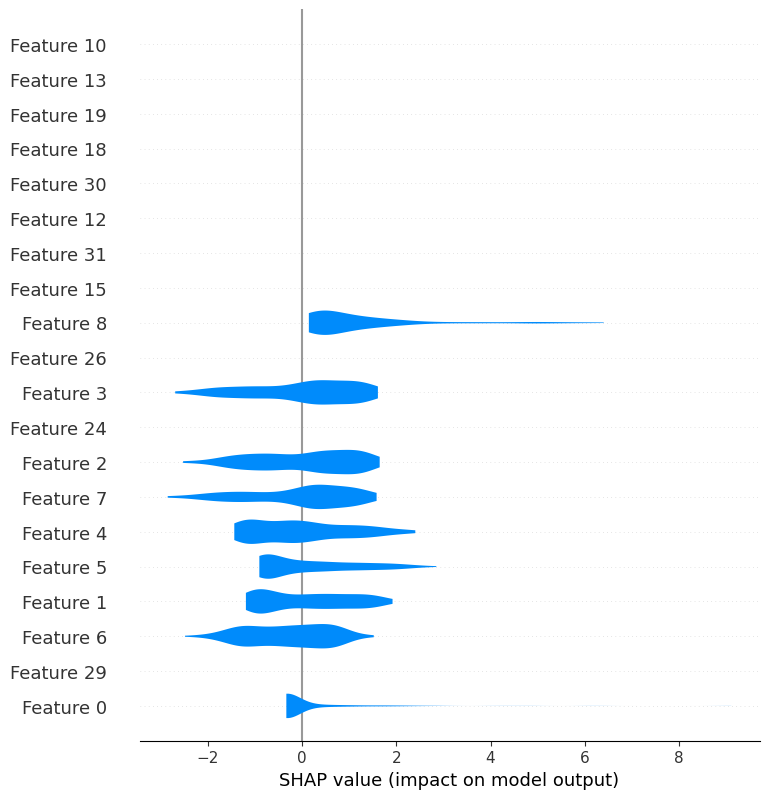

In [ ]:
shap.violin_plot(test_numpy)